In [ ]:
import numpy as np
import torch
import xarray as xr

import include as base
import matplotlib.pyplot as plt

In [300]:
from matplotlib import rcParams
from cycler import cycler
colors = {
    
    'c_darkblue': '#2F7194',
    'c_red': '#ec7070',
    'c_darkgreen': '#48675A',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_lightbrown': '#C6BFA2',
    'c_orange': '#EC9F7E',
    'c_yellow': '#F5DDA9',
    'c_darkgrey': '#3D4244',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightgrey': '#AFC1B9',
}
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
fs=9
rcParams.update(**{
    "text.usetex": True,
    "mathtext.fontset": "cm",
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amssymb} \usepackage{amsmath}",
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
    "grid.linewidth": 0.5,
    "savefig.bbox": "tight",
    "axes.grid": True,
    "axes.spines.top": False,
    "axes.spines.right": False
})

In [413]:
# Load in the UN data and drop the Holy See (NaNs only)
UN_data = xr.open_dataarray("/Users/thomasgaskin/UN_migration_data/UN_migration_estimates_country_area.nc").rename({"Region/Country/Area": "Country"})
UN_data = UN_data.drop_sel({"Country": "Holy See"})
training_data = torch.from_numpy(
    UN_data.transpose('Year', ...).data
).float()
N = training_data.shape[1]

torch.Size([72, 236])

In [241]:
# Initialise the Neural Network
NN = base.NeuralNet(
    input_size=N,
    output_size=N**2,
    num_layers=5,
    nodes_per_layer=dict(default=20),
    activation_funcs=dict(default='relu', layer_specific={-1: 'abs'}),
    biases=dict(default=[0, 1]),
    optimizer='Adam',
    learning_rate=0.002
)

In [242]:
# Train
num_epochs = 1000
batch_size = 35

loss_ts = []

# Train
for it in range(num_epochs):
    
    epoch_loss = []
    loss = torch.tensor(0.0, requires_grad=True)
    
    for j, dset in enumerate(training_data):

        # Make a prediction
        prediction = NN(dset).reshape(N, N)
        
        training_loss = (
            
            torch.nn.functional.mse_loss(torch.sum(prediction - torch.transpose(prediction, 0, 1), dim=0), dset)

            # Trace is zero
            + torch.trace(prediction)

            # Total should sum to zero
            + torch.sum(prediction - torch.transpose(prediction, 0, 1))
        )
        
        loss = loss +  training_loss
        
        if j % batch_size == 0 or j == training_data.shape[0] - 1:
            loss.backward()
            NN.optimizer.step()
            NN.optimizer.zero_grad()
            loss = torch.tensor(0.0, requires_grad=True)

        epoch_loss.append(training_loss.detach())
    
    loss_ts.append(np.mean(epoch_loss).item())
    
    print(f"Completed epoch {it+1}/{num_epochs}, current loss: {np.round(loss_ts[-1], 1)}", end="\r")

(0.0, 1.1)

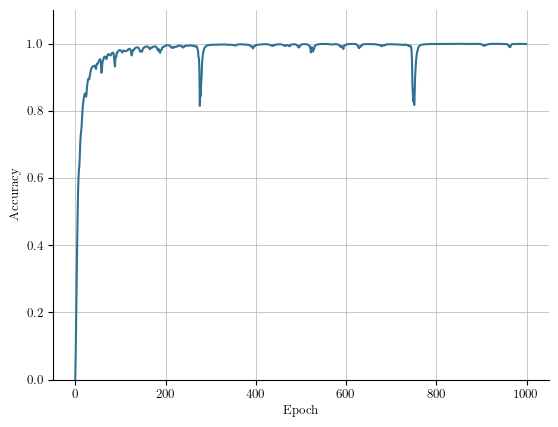

In [243]:
# Plot the training loss
fig, ax = plt.subplots()
ax.plot(np.arange(len(loss_ts)), 1-(np.array(loss_ts) / loss_ts[0]))
ax.set_ylabel("Accuracy")
ax.set_xlabel("Epoch")
ax.set_ylim(0, 1.1)

In [244]:
# Get predictions for each year
predicted_transport_plans = xr.DataArray(
    torch.stack([
    NN(dset).reshape(N, N).detach() for dset in training_data
]), dims=["Year", "i", "j"],
    coords={"Year": UN_data.coords["Year"].data,
            "i": UN_data.coords["Country"].data, "j": UN_data.coords["Country"].data}
)

# Get the predicted net migration for each year
predicted_net_migration = predicted_transport_plans.sum("i").rename({"j": "i"}) - predicted_transport_plans.sum("j")

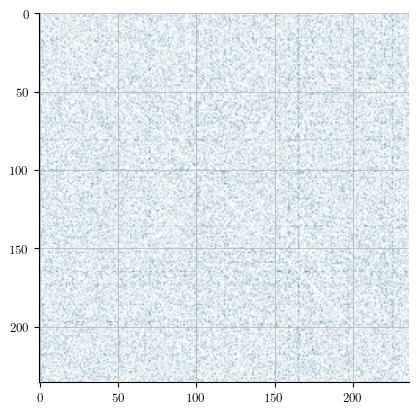

In [245]:
# Plot an example prediction on the training data
example_dset = training_data[2]
T_pred = NN(example_dset).reshape(N, N).detach()

from dantro.plot.utils import ColorManager
cm = ColorManager(
    cmap={'from_values': {0: 'white', 1: colors['c_darkblue']}, 'continuous': True}
)
fig, ax = plt.subplots()
ax.imshow(T_pred, cmap=cm.cmap)

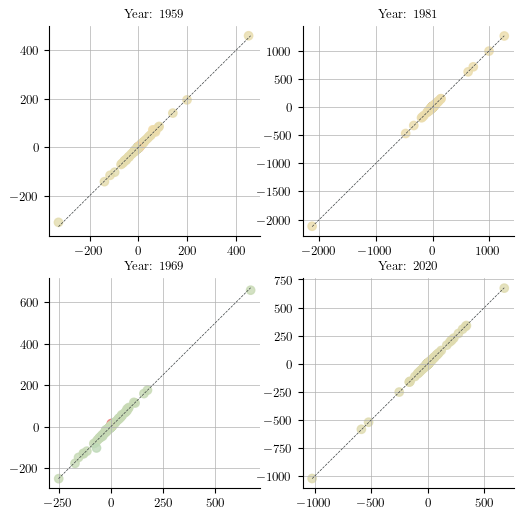

In [258]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(6, 6))

cm = ColorManager(
    cmap={'from_values': {0: colors['c_lightgreen'], 0.5: colors['c_yellow'], 1: colors['c_red']}, 'continuous': True}
)

for i in range(4):
    idx = np.random.choice(len(training_data), 1)[0]
    axs.flatten()[i].scatter(training_data[idx], predicted_net_migration[idx], c=abs(training_data[idx]-predicted_net_migration[idx])/training_data[idx], cmap=cm.cmap, alpha=0.8)
    min = np.minimum(training_data[idx].numpy().min(), predicted_net_migration[idx].min().item())
    max = np.maximum(training_data[idx].numpy().max(), predicted_net_migration[idx].max().item())
    axs.flatten()[i].plot(
        [min, max], [min, max], lw=0.5, color=colors['c_darkgrey'], linestyle='dashed'
    )
    axs.flatten()[i].set_title(f"Year: {UN_data.coords['Year'].data[idx]}")

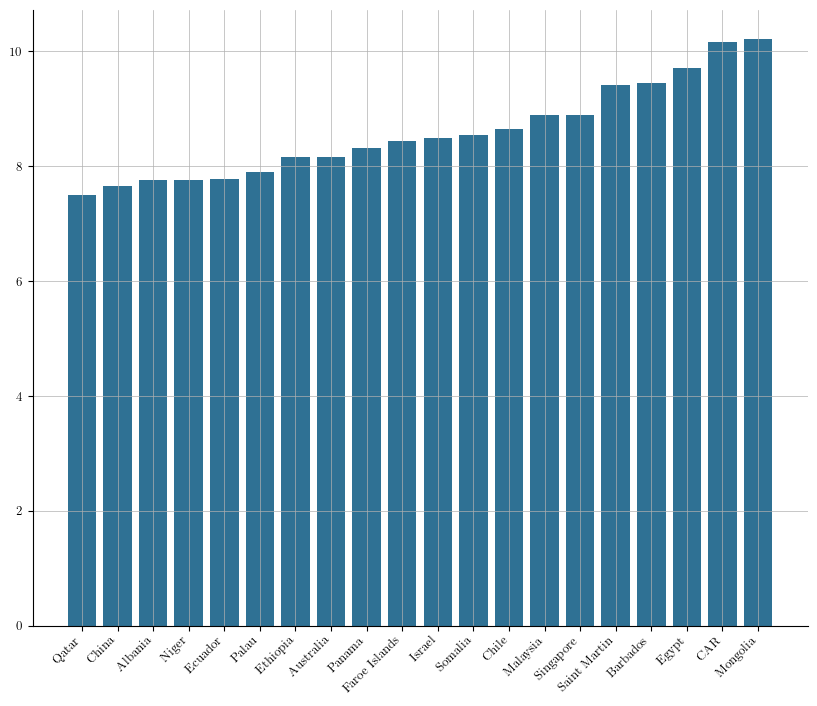

In [414]:
fig, ax = plt.subplots(figsize=(10, 8))
UK_in = predicted_transport_plans.sel({"Year": 2020, "j": "UK"}, drop=True)
UK_in = UK_in.isel({"i": UK_in.argsort().data[-20:]})
ax.bar(UK_in.coords["i"], UK_in)
_ = ax.set_xticks(UK_in.coords["i"].data, UK_in.coords["i"].data, rotation=45, ha='right')

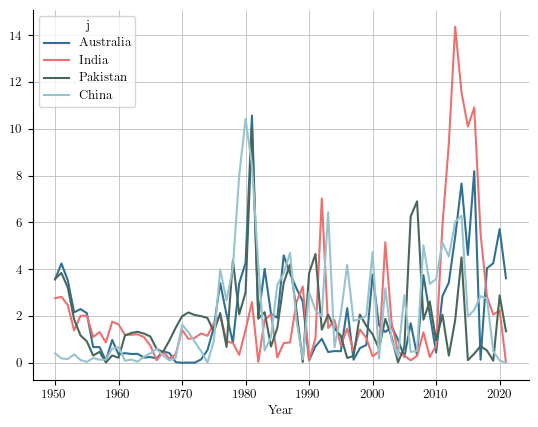

In [339]:
# fig, ax = plt.subplots()
UK_in = predicted_transport_plans.sel({"i": "USA"}, drop=True)
UK_in.sel({"j": ["Australia", "India", "Pakistan", "China"]}).plot.line(hue="j")
# for country in [:
#     ax.plot(UK_in.coords["Year"].data, UK_in.sel({"j": country}).data, label=country)
# ax.legend()

In [324]:
# Plot the predicted flow of migrants for a given year
# World map plot
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.feature import LAND, BORDERS
import networkx as nx
import pandas as pd 
from pyproj import Transformer


# Read the country coordinates
country_coords = pd.read_csv("/Users/thomasgaskin/FAOSTAT_data/Country_coords.csv", index_col=0)
nw = nx.DiGraph()

convert_countries = {
    'Bonaire, Sint Eustatius and Saba': 'Netherlands Antilles',
    'Brunei Darussalam': 'Brunei',
    'Cabo Verde': 'Cape Verde',
    'CAR': 'Central African Republic',
    'Macao': 'Macau',
    'Congo': 'Congo [Republic]',
    'DR Congo': 'Congo [DRC]',
    'Curaçao': 'Aruba',
    'Czechia': 'Czech Republic',
    'Eswatini': 'Swaziland',
    'North Macedonia': 'Macedonia [FYROM]',
    'Republic of Moldova': 'Moldova',
    'Saint Barthélemy': 'Anguilla',
    'Saint Martin': 'Anguilla',
    'S.Pierre-Miquelon': 'Saint Pierre and Miquelon',
    'Sao Tome and Principe': 'São Tomé and Príncipe',
    'Sint Marteen': 'Anguilla',
    'South Sudan': 'Sudan',
    'State of Palestine': 'Palestinian Territories',
    'Wallis-Futuna I.': 'Wallis and Futuna',
}

Year = 2021

pred = predicted_transport_plans.sel({"Year": Year}, drop=True)
# Add the exporters
for country in pred.coords['i'].data:
    
    if country in convert_countries.keys():
        country_conv = convert_countries[country]
    else:
        country_conv = country
    nw.add_node(country, pos=(country_coords.loc[country_conv]['latitude'],country_coords.loc[country_conv]['longitude']),
                net_migration=UN_data.sel({"Year": Year, "Country": country}))

# Add edges: des
for source in pred.coords['i'].data:
    for dest in pred.coords['j'].data:
        if source == dest:
            continue

        T = pred.sel({"i": source, "j": dest})
        if T > 4:
            nw.add_edge(source, dest, weight=T.data.item())

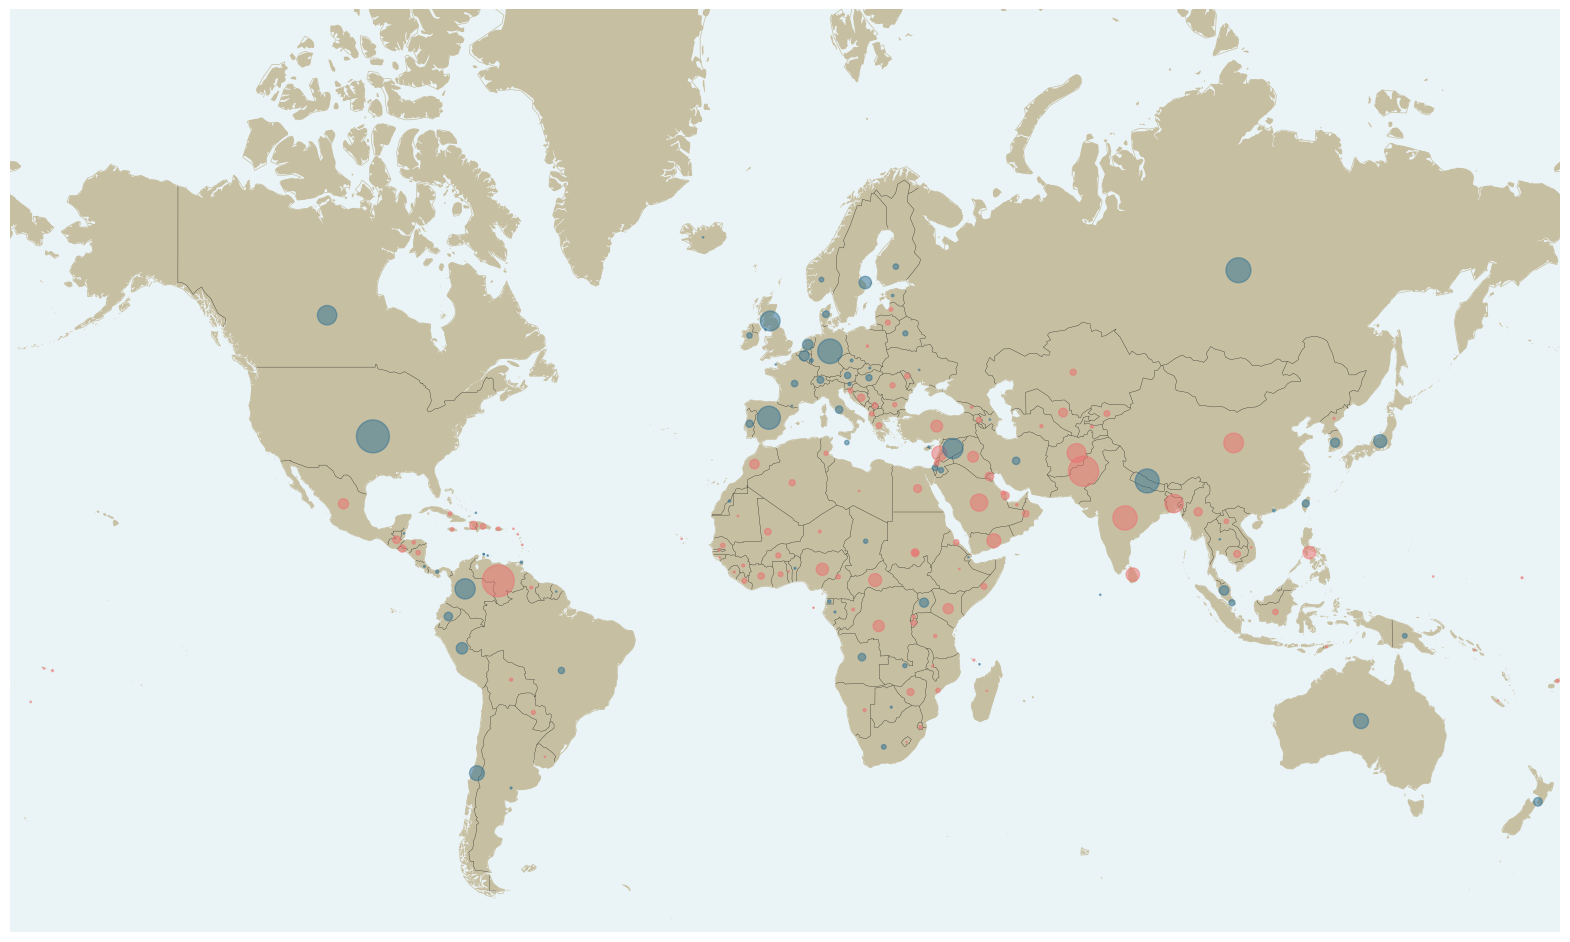

In [325]:
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw=dict(projection=ccrs.Mercator()))
ax.coastlines(color=colors['c_lightbrown'], lw=0.5)
land = cartopy.feature.NaturalEarthFeature('physical', 'land', '50m', facecolor=colors['c_lightbrown'])
sea = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '50m', facecolor=colors['c_lightblue'], alpha=0.2)
ax.axis('off')
ax.set_extent([-180, 180, -60, 80])
ax.add_feature(land, zorder=-2)
ax.add_feature(sea, zorder=-3)
ax.add_feature(BORDERS, lw=0.2, zorder=-1)
 
from pyproj import Transformer
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857")

# Plot the nodes
node_pos = dict((k, transformer.transform(*v)) for k, v in nx.get_node_attributes(nw, 'pos').items())
node_size = dict((k, abs(v)) for k, v in nx.get_node_attributes(nw, 'net_migration').items())
node_colors = [colors['c_red'] if v < 1 else colors['c_darkblue'] for v in nx.get_node_attributes(nw, 'net_migration').values()]
nx.draw_networkx_nodes(nw, node_pos, node_size=list(node_size.values()), ax=ax, node_color=node_colors, alpha=0.5)

# Plot the edges
edge_width = np.maximum(0.2, np.array(list(nx.get_edge_attributes(nw, 'weight').values())))
# _ = nx.draw_networkx_edges(nw, node_pos, ax=ax, width=edge_width / np.max(edge_width), alpha=0.3, 
#                            connectionstyle='arc3, rad=0.2', arrowsize=10)

In [406]:
# Now add the values for NZ and SWE to the loss function and train again
NZ_data = pd.read_csv("/Users/thomasgaskin/UN_migration_data/bilat_nzl.csv").set_index(["year", "direction", "country"]).drop("iso3c", axis=1)
NZ_data = NZ_data.to_xarray().drop_sel({"country": ["AFRICA AND THE MIDDLE EAST", "AMERICAS", "ASIA", "EUROPE", "OCEANIA", "NOT STATED", "TOTAL ALL COUNTRIES OF RESIDENCE"]}).rename({'country': 'Country'}).to_array().squeeze(drop=True)

In [415]:
NZ_data.shape

(41, 2, 246)

In [409]:
UN_data.shape

(72, 236)

In [411]:
print(len([country for country in UN_data.coords['Country'].data if country in NZ_data.coords['Country'].data]))

230


In [ ]:
T.sum(dim=1) - T.sum(dim=0)